## Modelo inicial de mora ≥ 30

In [ ]:
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_fscore_support
)

###  importar archivo sara

In [ ]:
#ruta_archivo = r"/content/drive/MyDrive/Cinco/yibi/Reto dentix/BD_numericas.xlsx"
#data = pd.read_excel(ruta_archivo)

#
#url = "https://docs.google.com/spreadsheets/d/1dEhrh3RKu6GMyufi88GnvG6kvXupKy2o/export?format=xlsx&gid=1335124019"
#
#data = pd.read_excel(url)

### importar archivo majo

In [ ]:
ruta_archivo_mj = r"/content/drive/MyDrive/yibi/BD_numericas.xlsx"
#data = pd.read_excel(ruta_archivo)

#
url = "https://docs.google.com/spreadsheets/d/1dEhrh3RKu6GMyufi88GnvG6kvXupKy2o/export?format=xlsx&gid=1335124019"
#
data = pd.read_excel(url)

###

---



Se eliminan las variables que se establecen a lo largo del tiempo, como su saldo vencido, la franja de mora, etc... pues terminarían influyendo en el modelo pero no sería aplicable en el contexto de la empresa, en dónde se busca predecir si un paciente tendrá o no más de treinta días de mora.

In [ ]:
df = data
df2 = df.copy()


Se quitan las columnas que sesgan la predicción de la mora

In [ ]:
drop = ['TARGET', 'FRANJA DE MORA', 'SALDO VENCIDO', 'SALDO CAPITAL', 'SCORE', 'PLAZO',
                    'TASA', 'MONTO PREAPROBADO', 'CUOTAMENSUAL', 'MONTO APROBADO', 'id']
df= data.drop(columns=drop)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45816 entries, 0 to 45815
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NIVEL ESTUDIOS            45816 non-null  int64  
 1   ESTADOCIVIL               45816 non-null  int64  
 2   GÉNERO                    44628 non-null  float64
 3   TIPO VIVIENDA             45816 non-null  int64  
 4   TIEMPO EN RESIDENCIA      45816 non-null  float64
 5   ESTRATO                   45816 non-null  int64  
 6   TIPO CONTRATO             45816 non-null  int64  
 7   TIEMPO ACTIVIDAD          45816 non-null  float64
 8   INGRESOS FIJOS            45816 non-null  int64  
 9   TOTAL INGRESOS            16268 non-null  float64
 10  GASTOS DE SOSTENIMIENTO   45369 non-null  float64
 11  ACTIVOS                   36683 non-null  float64
 12  MONTO DESEMBOLSO          45816 non-null  int64  
 13  IDENTIFICACION COMERCIAL  45816 non-null  int64  
 14  CODIGO

In [ ]:
df.isnull().sum()

,0
NIVEL ESTUDIOS,0
ESTADOCIVIL,0
GÉNERO,1188
TIPO VIVIENDA,0
TIEMPO EN RESIDENCIA,0
ESTRATO,0
TIPO CONTRATO,0
TIEMPO ACTIVIDAD,0
INGRESOS FIJOS,0
TOTAL INGRESOS,29548


In [ ]:
df = df.fillna(0)

Se establece que la variable objetivo es boleana, para determinar si los días de mora son más o menos de 30. Al contarlos, se observa como la gran mayoría de pacientes tiene una mora saludable.

In [ ]:
y = (df["DIAS DE MORA"] >= 30).astype(int)
                    # astype convierte el True/False de la condición a 1/0
print("0=<30, 1=≥30")
print(y.value_counts(normalize=True).rename("proporción").round(3))
# normalize=True te da porcentajes en vez de conteos en el value_counts
# .rename("proporción") cambia el nombre de la columna
# .round(3) redondea a 3 decimales

0=<30, 1=≥30
DIAS DE MORA
0    0.842
1    0.158
Name: proporción, dtype: float64


Una vez que ya se tiene la variable objetivo guardada, se puede eliminar la información de días de mora.

Se fraccionan los datos en categorías para entrenar y probar el modelo más adelante.

In [ ]:
x = df.drop(columns=["DIAS DE MORA"])
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.30, random_state=42, stratify=y
)

# stratify divide los datos de forma balanceada, poniendo 50% de 1's y 50% de 0's en ambas partes (test y train)

Vemos el resultado de stratify en las proporciones del split

In [ ]:
print("Proporción en TRAIN")
print(y_train.value_counts(normalize=True).round(3))

print("\nProporción en TEST")
print(y_test.value_counts(normalize=True).round(3))

Proporción en TRAIN
DIAS DE MORA
0    0.842
1    0.158
Name: proportion, dtype: float64

Proporción en TEST
DIAS DE MORA
0    0.842
1    0.158
Name: proportion, dtype: float64


SMOTE es una técnica para cuando tienes una minoría de clase, es decir que hay algún valor de la variable objetivo que tiene significativamente menos registros que la otra.

SMOTE - Synthetic Minority Oversampling Technique

Hace datos sintéticos de la clase con una minoría

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [ ]:
print(y_train.value_counts(normalize=True))        # antes
print(y_train_smote.value_counts(normalize=True))  # después

DIAS DE MORA
0    0.842163
1    0.157837
Name: proportion, dtype: float64
DIAS DE MORA
0    0.5
1    0.5
Name: proportion, dtype: float64


Ahora ya se puede definir el primer modelo:

In [ ]:
# pipelines
logit_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])

tree_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("clf", DecisionTreeClassifier(
        max_depth=5,               # árbol simple/baseline
        min_samples_leaf=50,       # para suavizar y evitar sobreajuste
        class_weight="balanced",   # útil si hay desbalance
        random_state=42
    ))
])

In [ ]:
# definición de función para evaluación | entrenar y sacar todas las métricas

def evaluar_modelo(nombre, pipe, X_train, X_test, y_train, y_test, thr=0.50):
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred  = (y_proba >= thr).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    print(f"\n=== {nombre} ===")
    print("matriz de confusión [[TN FP],[FN TP]]:\n", cm)

    print("\nreporte de clasificación:")
    print(classification_report(y_test, y_pred, digits=3))

    try:
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC: {roc_auc:.3f}")
    except Exception:
        roc_auc = np.nan
        print("ROC-AUC: N/A (no disponible)")

    # métricas compactas para comparar
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )

    resumen = {
        "modelo": nombre,
        "precision_pos": prec,
        "recall_pos": rec,
        "f1_pos": f1,
        "roc_auc": roc_auc
    }
    return pipe, resumen

In [ ]:
# entrenar y evaluar ambos modelos

logit_fitted, res_logit = evaluar_modelo("regresión logística", logit_pipe, X_train, X_test, y_train, y_test)
tree_fitted,  res_tree  = evaluar_modelo("árbol de decisión (simple)", tree_pipe, X_train, X_test, y_train, y_test)

comparativo = pd.DataFrame([res_logit, res_tree]).set_index("modelo")
print("\n=== comparativo (positiva = mora ≥30) ===")
print(comparativo.round(3))


=== regresión logística ===
matriz de confusión [[TN FP],[FN TP]]:
 [[6280 5295]
 [ 936 1234]]

reporte de clasificación:
              precision    recall  f1-score   support

           0      0.870     0.543     0.668     11575
           1      0.189     0.569     0.284      2170

    accuracy                          0.547     13745
   macro avg      0.530     0.556     0.476     13745
weighted avg      0.763     0.547     0.608     13745

ROC-AUC: 0.578

=== árbol de decisión (simple) ===
matriz de confusión [[TN FP],[FN TP]]:
 [[6701 4874]
 [ 968 1202]]

reporte de clasificación:
              precision    recall  f1-score   support

           0      0.874     0.579     0.696     11575
           1      0.198     0.554     0.292      2170

    accuracy                          0.575     13745
   macro avg      0.536     0.566     0.494     13745
weighted avg      0.767     0.575     0.633     13745

ROC-AUC: 0.594

=== comparativo (positiva = mora ≥30) ===
                    

In [ ]:
# logística -> coeficientes y odds ratios
try:
    clf = logit_fitted.named_steps["clf"]
    coefs = pd.DataFrame({
        "feature": num_cols,
        "coef": clf.coef_.ravel()
    })
    coefs["odds_ratio"] = np.exp(coefs["coef"])
    coefs["|coef|"] = coefs["coef"].abs()
    top_logit = coefs.sort_values("|coef|", ascending=False).head(15)
    print("\ntop 15 features (logística) por |coef|:")
    print(top_logit[["feature", "coef", "odds_ratio"]].to_string(index=False))
except Exception as e:
    print("\nNno se pudieron extraer coeficientes de la logística:", e)

# importancias
try:
    importancias = pd.DataFrame({
        "feature": num_cols,
        "importance": tree_fitted.named_steps["clf"].feature_importances_
    }).sort_values("importance", ascending=False).head(15)
    print("\ntop 15 features (árbol) por importancia:")
    print(importancias.to_string(index=False))
except Exception as e:
    print("\nno se pudieron extraer importancias del árbol:", e)

# umbral que maximiza F1 en test

def mejor_umbral_f1(y_true, y_score):
    from sklearn.metrics import f1_score
    thrs = np.linspace(0.05, 0.95, 19)
    puntajes = [(t, f1_score(y_true, (y_score >= t).astype(int))) for t in thrs]
    return max(puntajes, key=lambda x: x[1])

for nombre, modelo in [("logística", logit_fitted), ("árbol", tree_fitted)]:
    y_proba = modelo.predict_proba(X_test)[:, 1]
    t, f1b = mejor_umbral_f1(y_test, y_proba)
    print(f"\numbral sugerido (max F1) para {nombre}: {t:.2f} — F1={f1b:.3f}")



Nno se pudieron extraer coeficientes de la logística: name 'num_cols' is not defined

no se pudieron extraer importancias del árbol: name 'num_cols' is not defined

umbral sugerido (max F1) para logística: 0.40 — F1=0.285

umbral sugerido (max F1) para árbol: 0.45 — F1=0.297


Graficamos el arbol resultante

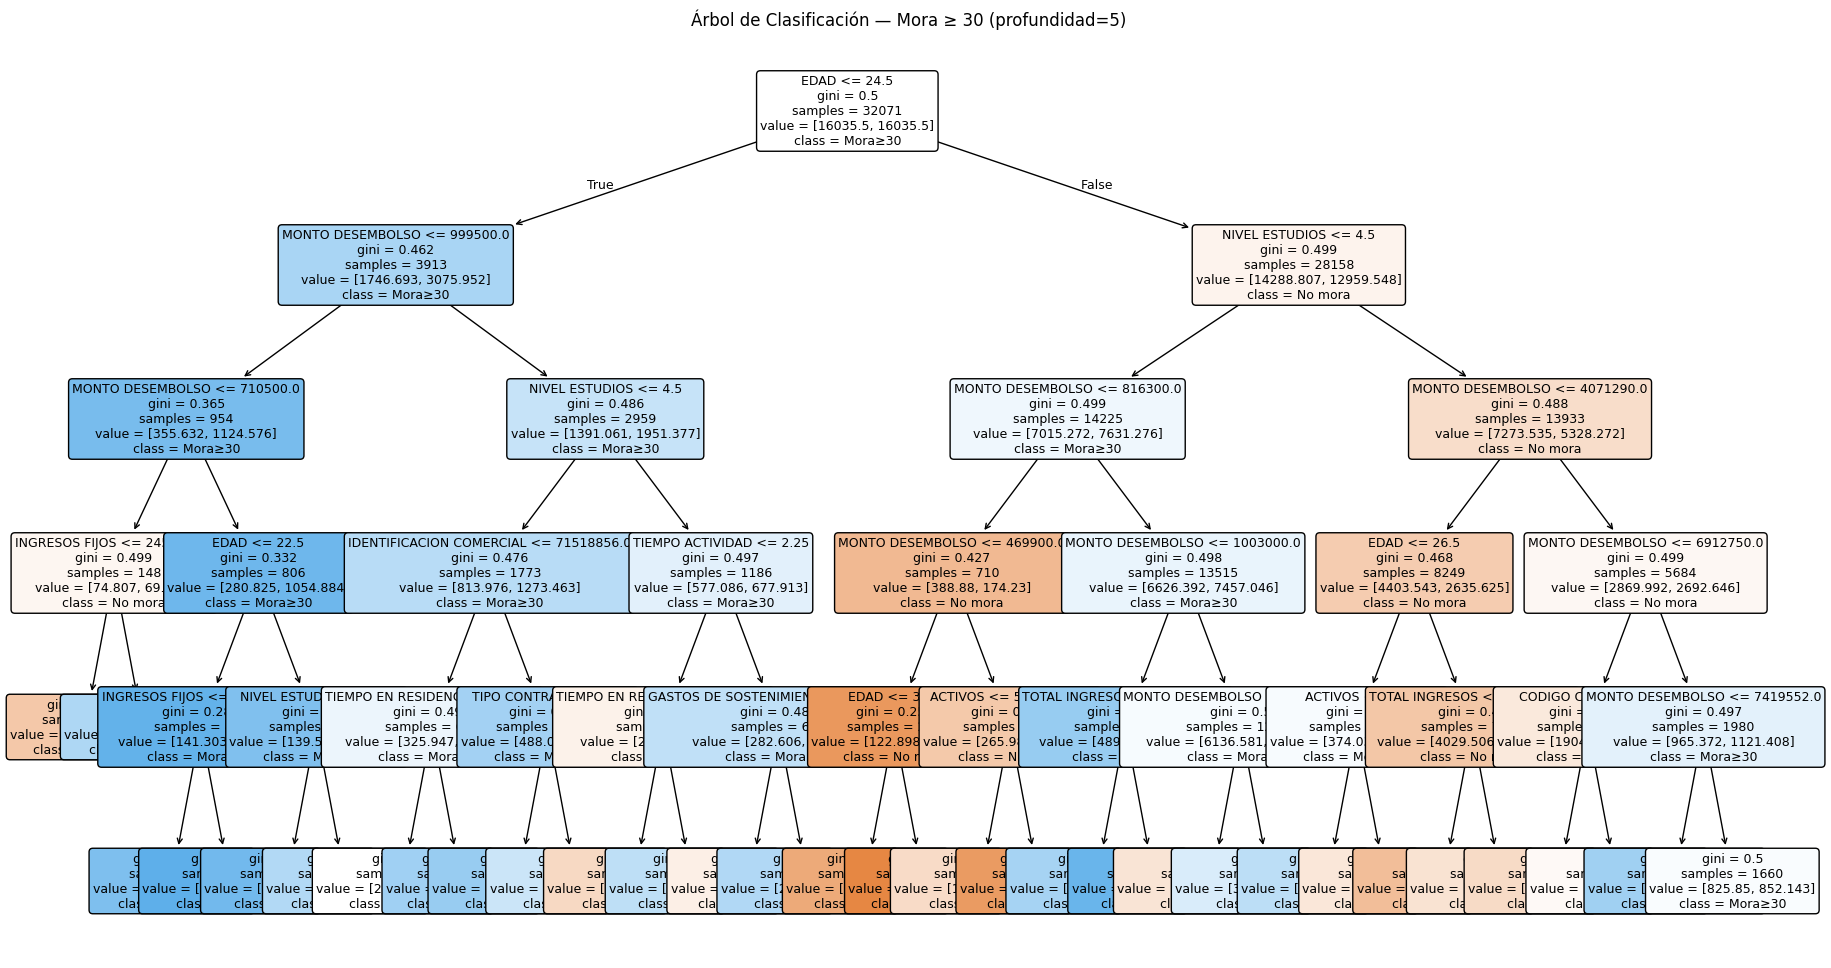

In [ ]:
num_cols = X_train.columns.tolist()

clf = tree_fitted.named_steps["clf"]

plt.figure(figsize=(22, 12))
tree.plot_tree(
    clf,
    feature_names=num_cols,
    class_names=["No mora", "Mora≥30"],
    filled=True,
    rounded=True,
    fontsize=9
)
plt.title("Árbol de Clasificación — Mora ≥ 30 (profundidad=%d)" % clf.get_depth())
plt.show()



Buscando los mejores parametros

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "clf__max_depth": [3, 5, 7, 9, 12],
    "clf__min_samples_leaf": [10, 20, 50, 100],
    "clf__ccp_alpha": [0.0, 0.001, 0.005, 0.01]
}

grid = GridSearchCV(
    estimator=tree_pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Mejores parámetros:", grid.best_params_)

best_tree = grid.best_estimator_
y_proba_best = best_tree.predict_proba(X_test)[:, 1]
y_pred_best = (y_proba_best >= 0.45).astype(int)

Mejores parámetros: {'clf__ccp_alpha': 0.0, 'clf__max_depth': 5, 'clf__min_samples_leaf': 100}


## Modelo de clasificación

**Modelo reentrenado**

En nuestro primer modelo de árbol de decisión se aplicón un reentrenamiento utilizando los parámetros obtenidos a través de Grid Search. Los resultados indicaron el mismo valor óptimo de profundiad (max_depth = 5), pero se incrementó el parámetro min_samples_leaf de 50 a 100 con el objetivo de reducir el sobreajuste y mejorar la generalización del modelo. Tras este ajuste el modelo presentó una ligera mejora en su desempeño, especialmente en la estabilidad de las métricas de validación, manteniendo un valor similar de ROC-AUC (~0.59) pero con un incremento moderado en la prescisión y en la relación entre recall y f1-score. Esto indica que el árbol logró un equilibrio más adecuado entre sensibilidad y especificidad, reduciendo la varianza sin compromoter la capacidad predictiva.

In [ ]:
tree_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("clf", DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=100,
        ccp_alpha=0.0,
        class_weight="balanced",
        random_state=42
    ))
])

tree_pipe.fit(X_train, y_train)


y_pred = tree_pipe.predict(X_test)
y_proba = tree_pipe.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0      0.872     0.597     0.708     11575
           1      0.198     0.531     0.289      2170

    accuracy                          0.586     13745
   macro avg      0.535     0.564     0.499     13745
weighted avg      0.765     0.586     0.642     13745

ROC-AUC: 0.5939924953469161


Tras el ajuste de hiperparámetros mediante validación cruzada, el árbol de decisión mantuvo un rendimiento similar (F1 ≈ 0.29, AUC ≈ 0.59), pero mostró una mejora leve en accuracy y estabilidad general. El parámetro óptimo ccp_alpha = 0.0 confirma que no se requería poda adicional, ya que el árbol está regularizado por su profundidad y el número mínimo de observaciones por hoja. El modelo resultante es más simple, más interpretable y menos propenso al sobreajuste, siendo adecuado como modelo de referencia inicial para mora ≥ 30 días.

In [ ]:
clf = tree_pipe.named_steps["clf"]

importances = pd.DataFrame({
    "variable": X_train.columns,
    "importancia": clf.feature_importances_
}).sort_values("importancia", ascending=False)

# Mostrar las 15 más importantes
print(importances.head(15))

                    variable  importancia
12          MONTO DESEMBOLSO     0.440968
15                      EDAD     0.276006
0             NIVEL ESTUDIOS     0.154809
9             TOTAL INGRESOS     0.046673
11                   ACTIVOS     0.018866
13  IDENTIFICACION COMERCIAL     0.015798
4       TIEMPO EN RESIDENCIA     0.011497
7           TIEMPO ACTIVIDAD     0.010167
14               CODIGO CIIU     0.009924
6              TIPO CONTRATO     0.005634
10   GASTOS DE SOSTENIMIENTO     0.005318
5                    ESTRATO     0.004339
3              TIPO VIVIENDA     0.000000
8             INGRESOS FIJOS     0.000000
1                ESTADOCIVIL     0.000000


**Probamos el DT pero ahora con las variables SCORE y TASA**

En el segundo conjunto de datos (df2) se realizaron modificaciones clave respecto al df1 con el propósito de mejorar el rendimiento del modelo. En esta versión se agregaron las variables SCORE y TASA, ya que durante el análisis de componentes principales (PCA) demostraron ser relevantes para la separación de los individuos. Asimismo, se eliminó la variable DIAS EN APROBAR debido a que presentaba una varianza cercana a cero, lo que indica que no aportaba información significativa al modelo. Además, se mantuvieron eliminadas las mismas variables que en el primer dataset para conservar la consistencia del experimento. Posteriormente, se aplicó nuevamente el proceso de ajuste de hiperparámetros mediante Grid Search, aunque en este caso el resultado no mostró una mejora con respecto al modelo anterior.


A pesar de ello, el df2 logró una ligera mejora en las métricas de desempeño, principalmente en la precisión y el f1-score, lo que sugiere que la inclusión de las variables SCORE y TASA aportó información útil para la clasificación. Específicamente, el modelo mostró un mejor equilibrio entre precisión y recall en la clase positiva, indicando una mejora en la identificación de los individuos con mayor probabilidad de presentar mora en comparación con el modelo entrenado con el df1.

In [ ]:
print(df2.columns.tolist())

['id', 'NIVEL ESTUDIOS', 'ESTADOCIVIL', 'GÉNERO', 'TIPO VIVIENDA', 'TIEMPO EN RESIDENCIA', 'ESTRATO', 'TIPO CONTRATO', 'TIEMPO ACTIVIDAD', 'INGRESOS FIJOS', 'TOTAL INGRESOS', 'GASTOS DE SOSTENIMIENTO', 'ACTIVOS', 'MONTO PREAPROBADO', 'MONTO APROBADO', 'PLAZO', 'MONTO DESEMBOLSO', 'IDENTIFICACION COMERCIAL', 'TASA', 'CUOTAMENSUAL', 'CODIGO CIIU', 'SCORE', 'SALDO CAPITAL', 'SALDO VENCIDO', 'DIAS DE MORA', 'FRANJA DE MORA', 'EDAD', 'DIAS EN APROBAR', 'TARGET']


In [ ]:
df["DIAS EN APROBAR"].describe()

,DIAS EN APROBAR
count,45816.000000
mean,0.001659
std,0.052416
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3.000000


In [ ]:
drop = ['TARGET', 'FRANJA DE MORA', 'SALDO VENCIDO', 'SALDO CAPITAL', 'PLAZO',
                     'MONTO PREAPROBADO', 'CUOTAMENSUAL', 'MONTO APROBADO', 'id','IDENTIFICACION COMERCIAL','DIAS EN APROBAR']
df2 = df2.drop(columns=drop)

In [ ]:
y = (df2["DIAS DE MORA"] >= 30).astype(int)
X = df2.drop(columns=["DIAS DE MORA"])

num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numéricas:", len(num_cols), "| Categóricas:", len(cat_cols))

Numéricas: 17 | Categóricas: 0


In [ ]:

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

In [ ]:
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh",  OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

tree_pipe2 = Pipeline([
    ("pre", pre),
    ("clf", DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=200,
        ccp_alpha=0.0,
        class_weight="balanced",
        random_state=42
    ))
])

In [ ]:
tree_pipe2.fit(x_train, y_train)

y_proba = tree_pipe2.predict_proba(x_test)[:, 1]

ths = np.linspace(0.05, 0.95, 19)
t_best, f1_best = max(((t, f1_score(y_test, (y_proba>=t).astype(int))) for t in ths), key=lambda z: z[1])

y_pred = (y_proba >= t_best).astype(int)

print(f"Umbral óptimo por F1: {t_best:.2f}  |  F1={f1_best:.3f}")
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Matriz de confusión [[TN FP],[FN TP]]:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=3))

Umbral óptimo por F1: 0.55  |  F1=0.323
ROC-AUC: 0.644506673567497
Matriz de confusión [[TN FP],[FN TP]]:
 [[8045 3530]
 [1072 1098]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.882     0.695     0.778     11575
           1      0.237     0.506     0.323      2170

    accuracy                          0.665     13745
   macro avg      0.560     0.601     0.550     13745
weighted avg      0.781     0.665     0.706     13745



In [ ]:

feat_names = tree_pipe2.named_steps["pre"].get_feature_names_out()
importances = tree_pipe2.named_steps["clf"].feature_importances_

imp_df = (pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False))

print("\nTop 20 features:")
print(imp_df.head(20).to_string(index=False))


Top 20 features:
                     feature  importance
                  num__SCORE    0.637073
       num__MONTO DESEMBOLSO    0.216486
                   num__TASA    0.099518
         num__NIVEL ESTUDIOS    0.018517
num__GASTOS DE SOSTENIMIENTO    0.009308
         num__TOTAL INGRESOS    0.009283
       num__TIEMPO ACTIVIDAD    0.004924
   num__TIEMPO EN RESIDENCIA    0.004890
                 num__GÉNERO    0.000000
         num__INGRESOS FIJOS    0.000000
          num__TIPO CONTRATO    0.000000
                num__ESTRATO    0.000000
          num__TIPO VIVIENDA    0.000000
            num__ESTADOCIVIL    0.000000
                num__ACTIVOS    0.000000
            num__CODIGO CIIU    0.000000
                   num__EDAD    0.000000


In [ ]:
param_grid = {
    "clf__max_depth": [4,5,6,8],
    "clf__min_samples_leaf": [50,100,200],
    "clf__ccp_alpha": [0.0, 0.001, 0.005]
}

grid = GridSearchCV(
    estimator=Pipeline([("pre", pre), ("clf", DecisionTreeClassifier(class_weight="balanced", random_state=42))]),
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid.fit(x_train, y_train)
print("Mejores parámetros:", grid.best_params_)

best_tree = grid.best_estimator_
proba_g = best_tree.predict_proba(x_test)[:,1]
t_g, f1_g = max(((t, f1_score(y_test, (proba_g>=t).astype(int))) for t in ths), key=lambda z: z[1])
print(f"F1 con mejor árbol (CV): {f1_g:.3f} | Umbral: {t_g:.2f} | AUC: {roc_auc_score(y_test, proba_g):.3f}")

Mejores parámetros: {'clf__ccp_alpha': 0.0, 'clf__max_depth': 4, 'clf__min_samples_leaf': 200}
F1 con mejor árbol (CV): 0.323 | Umbral: 0.45 | AUC: 0.644


**Random Forest con el df2**

In [ ]:
y = (df2["DIAS DE MORA"] >= 30).astype(int)
X = df2.drop(columns=["DIAS DE MORA"])

num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh",  OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
])

rf_pipe = Pipeline([
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        max_depth=10,
        min_samples_leaf=50,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    ))
])

rf_pipe.fit(x_train, y_train)

y_proba = rf_pipe.predict_proba(x_test)[:,1]

ths = np.linspace(0.05, 0.95, 19)
t_best, f1_best = max(((t, f1_score(y_test, (y_proba>=t).astype(int))) for t in ths), key=lambda z: z[1])
y_pred = (y_proba >= t_best).astype(int)

print(f"Umbral óptimo (F1): {t_best:.2f}  |  F1={f1_best:.3f}")
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Matriz de confusión [[TN FP],[FN TP]]:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=3))

Umbral óptimo (F1): 0.45  |  F1=0.334
ROC-AUC: 0.6624723552069751
Matriz de confusión [[TN FP],[FN TP]]:
 [[6277 5298]
 [ 675 1495]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.903     0.542     0.678     11575
           1      0.220     0.689     0.334      2170

    accuracy                          0.565     13745
   macro avg      0.561     0.616     0.506     13745
weighted avg      0.795     0.565     0.623     13745



In [ ]:
feat_names = rf_pipe.named_steps["pre"].get_feature_names_out()
imp = rf_pipe.named_steps["clf"].feature_importances_
imp_df = (pd.DataFrame({"feature": feat_names, "importance": imp})
            .sort_values("importance", ascending=False))
print("\nTop 20 features:")
print(imp_df.head(20).to_string(index=False))


Top 20 features:
                     feature  importance
                  num__SCORE    0.316984
       num__MONTO DESEMBOLSO    0.144213
                   num__TASA    0.137995
                   num__EDAD    0.072380
         num__NIVEL ESTUDIOS    0.045693
         num__INGRESOS FIJOS    0.041017
   num__TIEMPO EN RESIDENCIA    0.037741
                num__ACTIVOS    0.036173
       num__TIEMPO ACTIVIDAD    0.035664
num__GASTOS DE SOSTENIMIENTO    0.033783
         num__TOTAL INGRESOS    0.028157
            num__CODIGO CIIU    0.020989
            num__ESTADOCIVIL    0.014980
                num__ESTRATO    0.013063
                 num__GÉNERO    0.007627
          num__TIPO CONTRATO    0.006792
          num__TIPO VIVIENDA    0.006749


Entrenamiento solo con las variables del RF

In [ ]:
selected_vars = [
    'SCORE',
    'MONTO DESEMBOLSO',
    'TASA',
    'EDAD',
    'NIVEL ESTUDIOS',
    'INGRESOS FIJOS',
    'TIEMPO EN RESIDENCIA',
    'ACTIVOS',
    'TIEMPO ACTIVIDAD',
    'GASTOS DE SOSTENIMIENTO',
    'TOTAL INGRESOS',
    'CODIGO CIIU',
    'ESTADOCIVIL',
    'ESTRATO'
]

In [ ]:

X_sel = df2[selected_vars]
y = (df2["DIAS DE MORA"] >= 30).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y, test_size=0.30, random_state=42, stratify=y
)

tree_sel = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("clf", DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=100,
        class_weight="balanced",
        random_state=42
    ))
])

tree_sel.fit(X_train, y_train)

y_proba = tree_sel.predict_proba(X_test)[:, 1]

ths = np.linspace(0.05, 0.95, 19)
t_best, f1_best = max(((t, f1_score(y_test, (y_proba>=t).astype(int))) for t in ths), key=lambda x: x[1])
y_pred = (y_proba >= t_best).astype(int)

print(f"Umbral óptimo (F1): {t_best:.2f}  |  F1={f1_best:.3f}")
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=3))

Umbral óptimo (F1): 0.55  |  F1=0.323
ROC-AUC: 0.6446445641030745
              precision    recall  f1-score   support

           0      0.883     0.691     0.775     11575
           1      0.236     0.511     0.323      2170

    accuracy                          0.662     13745
   macro avg      0.560     0.601     0.549     13745
weighted avg      0.781     0.662     0.704     13745



Punto 6: Regresion

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

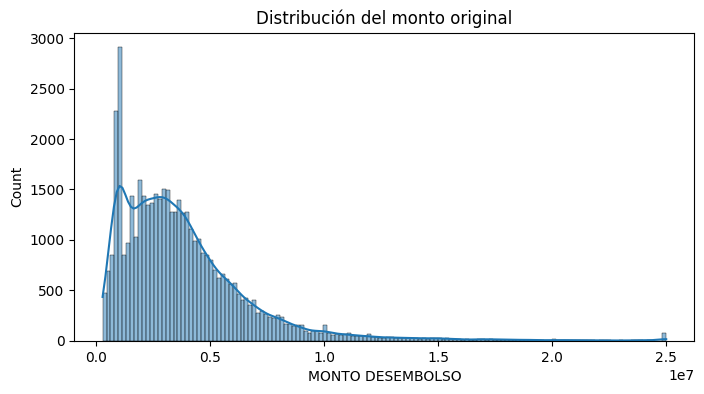

count    4.581600e+04
mean     3.822836e+06
std      2.997837e+06
min      2.700000e+05
25%      1.820000e+06
50%      3.187450e+06
75%      4.925700e+06
max      2.500000e+07
Name: MONTO DESEMBOLSO, dtype: float64


In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df["MONTO DESEMBOLSO"], kde=True)
plt.title("Distribución del monto original")
plt.show()

print(df["MONTO DESEMBOLSO"].describe())

In [ ]:
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

In [ ]:
cols_leak = [
    "MONTO DESEMBOLSO", "MONTO APROBADO", "MONTO PREAPROBADO",
    "SALDO VENCIDO", "SALDO CAPITAL",
    "FRANJA DE MORA", "DIAS DE MORA", "TARGET",
    "IDENTIFICACION COMERCIAL", "DIAS EN APROBAR"
]

y = df["MONTO DESEMBOLSO"].copy()
X = df.drop(columns=[c for c in cols_leak if c in df.columns]).copy()

num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

In [ ]:
#Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

In [ ]:
#Preprocesamiento
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
])

lin_plain = Pipeline([
    ("pre", pre),
    ("reg", LinearRegression())
])

lin_log = Pipeline(steps=[
    ("pre", Pipeline(steps=[
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])),
    ("reg", LinearRegression())
])

In [ ]:
def evaluar(nombre, model):
    model.fit(X_train, y_train)
    yp = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, yp))
    r2   = r2_score(y_test, yp)
    print(f"\n=== {nombre} ===")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²:   {r2:.3f}")
    return rmse, r2

rmse_plain, r2_plain = evaluar("Lineal (sin transformación)", lin_plain)
rmse_log,   r2_log   = evaluar("Lineal (objetivo log-transformado)", lin_log)


lin_plain.fit(X_train, y_train)
feat_names = lin_plain.named_steps["pre"].get_feature_names_out()
coef = lin_plain.named_steps["reg"].coef_
coef_df = (pd.DataFrame({"feature": feat_names, "coef": coef})
           .sort_values("coef", ascending=False))
print("\nTop 15 coeficientes (+):")
print(coef_df.head(15).to_string(index=False))
print("\nTop 15 coeficientes (-):")
print(coef_df.tail(15).to_string(index=False))


=== Lineal (sin transformación) ===
RMSE: 2,914,028.75
R²:   0.058

=== Lineal (objetivo log-transformado) ===
RMSE: 2,914,028.75
R²:   0.058

Top 15 coeficientes (+):
                     feature          coef
       num__TIEMPO ACTIVIDAD 330771.974892
                num__ESTRATO 257419.590932
                   num__EDAD 236438.505339
         num__NIVEL ESTUDIOS 170576.084573
            num__CODIGO CIIU  81406.222128
         num__INGRESOS FIJOS  67758.957251
   num__TIEMPO EN RESIDENCIA  45376.498008
          num__TIPO CONTRATO  36161.930855
            num__ESTADOCIVIL  16055.404334
         num__TOTAL INGRESOS  -2192.693663
num__GASTOS DE SOSTENIMIENTO  -9512.512953
                num__ACTIVOS -15665.918283
          num__TIPO VIVIENDA -83642.430668
                 num__GÉNERO -91064.146020

Top 15 coeficientes (-):
                     feature          coef
       num__TIEMPO ACTIVIDAD 330771.974892
                num__ESTRATO 257419.590932
                   num__EDAD 23

## Regresión lineal de monto

In [ ]:
df.head()

,NIVEL ESTUDIOS,ESTADOCIVIL,GÉNERO,TIPO VIVIENDA,TIEMPO EN RESIDENCIA,ESTRATO,TIPO CONTRATO,TIEMPO ACTIVIDAD,INGRESOS FIJOS,TOTAL INGRESOS,GASTOS DE SOSTENIMIENTO,ACTIVOS,MONTO DESEMBOLSO,IDENTIFICACION COMERCIAL,CODIGO CIIU,DIAS DE MORA,EDAD,DIAS EN APROBAR
0,5,0,0.0,2,3.0,5,0,5.0,13000000,15500000.0,35000.0,350000000.0,13990500,1101203671,8560,0,42,0
1,3,0,1.0,1,21.0,4,1,21.0,19000000,19000000.0,10000.0,0.0,5141500,1045679685,4610,0,60,0
2,3,3,1.0,2,15.0,3,0,1.0,1500000,1500000.0,500000.0,15000000.0,1259000,1026291187,4799,0,20,0
3,3,3,1.0,1,7.0,4,0,4.0,4000000,7500000.0,600000.0,0.0,2548000,31711538,9609,0,29,0
4,5,0,1.0,1,19.0,4,2,1.0,16000000,16000000.0,50000.0,0.0,1877204,1083558670,4799,0,18,0


Utilizamos el df1 inicial para la implementación del modelo, y a partir de este haremos los siguientes cambios. Evitamos las columnas que no debe ver el modelo porque ya contienen la respuesta o cosas muy ligadas al monto


In [ ]:
# eliminar outliers

p99 = df["MONTO DESEMBOLSO"].quantile(0.99)
p995 = df["MONTO DESEMBOLSO"].quantile(0.995)

p99, p995

(np.float64(15475754.999999989), np.float64(18757748.475000188))

In [ ]:
df_reg = df[df["MONTO DESEMBOLSO"] <= 1000000].copy()

In [ ]:
columnas_leak = [
    "MONTO DESEMBOLSO", "MONTO APROBADO", "MONTO PREAPROBADO",
    "SALDO VENCIDO", "SALDO CAPITAL",
    "FRANJA DE MORA", "DIAS DE MORA", "TARGET",
    "IDENTIFICACION COMERCIAL", "DIAS EN APROBAR"
]

# target
y = df_reg["MONTO DESEMBOLSO"].copy()

# features sin columnas leaks
X = df_reg.drop(columns=[c for c in cols_leak if c in df.columns]).copy()


In [ ]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 11 to 45815
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NIVEL ESTUDIOS            6497 non-null   int64  
 1   ESTADOCIVIL               6497 non-null   int64  
 2   GÉNERO                    6497 non-null   float64
 3   TIPO VIVIENDA             6497 non-null   int64  
 4   TIEMPO EN RESIDENCIA      6497 non-null   float64
 5   ESTRATO                   6497 non-null   int64  
 6   TIPO CONTRATO             6497 non-null   int64  
 7   TIEMPO ACTIVIDAD          6497 non-null   float64
 8   INGRESOS FIJOS            6497 non-null   int64  
 9   TOTAL INGRESOS            6497 non-null   float64
 10  GASTOS DE SOSTENIMIENTO   6497 non-null   float64
 11  ACTIVOS                   6497 non-null   float64
 12  MONTO DESEMBOLSO          6497 non-null   int64  
 13  IDENTIFICACION COMERCIAL  6497 non-null   int64  
 14  CODIGO CIIU

Definimos el pipeline y dividimos los datos

In [ ]:
# separar numéricas y categóricas
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

In [ ]:
# pipelines de preprocesamiento
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
])


Se implementan dos modelos. Lineal normal y lineal con log(target)

In [ ]:
# modelo 1: lineal normal
lin_plain = Pipeline([
    ("pre", pre),
    ("reg", LinearRegression())
])

# modelo 2: lineal con target log-transformado
lin_log = Pipeline([
    ("pre", pre),
    ("reg", LinearRegression())
])

Evaluamos

In [ ]:
# definición de función para evaluación

def evaluar_reg(nombre, modelo, X_train, X_test, y_train, y_test, log_target=False):
    if log_target:
        # entrenamos en log1p(y)
        y_train_fit = np.log1p(y_train)
        modelo.fit(X_train, y_train_fit)
        # predecimos y regresamos a la escala original
        y_pred = np.expm1(modelo.predict(X_test))
    else:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)

    print(f"\n=== {nombre} ===")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²:   {r2:.3f}")

    return y_pred, rmse, r2

In [ ]:
y_pred_plain, rmse_plain, r2_plain = evaluar_reg(
    "lineal", lin_plain,
    X_train, X_test, y_train, y_test,
    log_target=False
)

y_pred_log, rmse_log, r2_log = evaluar_reg(
    "lineal (objetivo log-transformado)", lin_log,
    X_train, X_test, y_train, y_test,
    log_target=True
)


=== lineal ===
RMSE: 189,916.67
R²:   0.052

=== lineal (objetivo log-transformado) ===
RMSE: 191,934.86
R²:   0.032


Se puede graficar el residuo obtenido de cada modelo para una mejor apreciación de las métricas

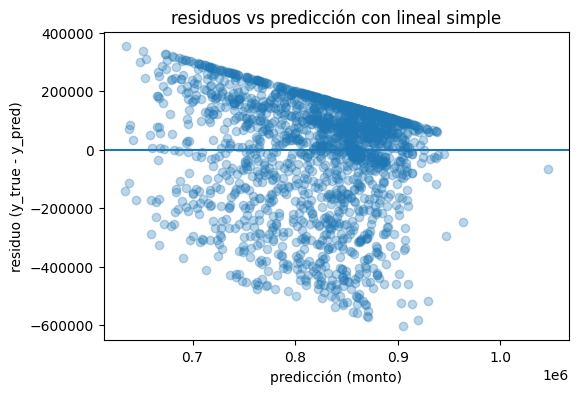

In [ ]:
resid_plain = y_test - y_pred_plain

plt.figure(figsize=(6,4))
plt.scatter(y_pred_plain, resid_plain, alpha=0.3)
plt.axhline(0)
plt.xlabel("predicción (monto)")
plt.ylabel("residuo (y_true - y_pred)")
plt.title("residuos vs predicción con lineal simple")
plt.show()

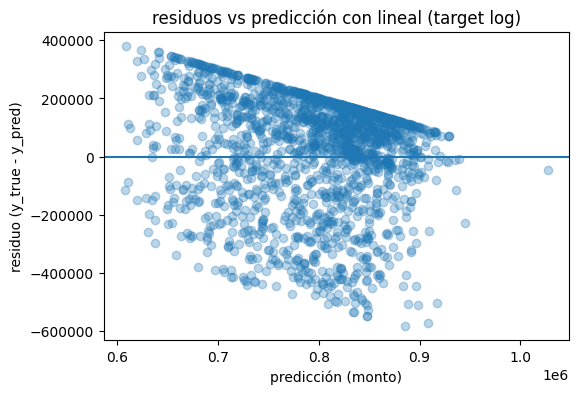

In [ ]:
resid_log = y_test - y_pred_log

plt.figure(figsize=(6,4))
plt.scatter(y_pred_log, resid_log, alpha=0.3)
plt.axhline(0)
plt.xlabel("predicción (monto)")
plt.ylabel("residuo (y_true - y_pred)")
plt.title("residuos vs predicción con lineal (target log)")
plt.show()

In [ ]:
lin_plain.fit(X_train, y_train)

feat_names = lin_plain.named_steps["pre"].get_feature_names_out()
coefs = lin_plain.named_steps["reg"].coef_

coef_df = (pd.DataFrame({"feature": feat_names, "coef": coefs})
           .sort_values("coef", ascending=False))

print("\ntop 10 coeficientes (+):")
print(coef_df.head(15).to_string(index=False))

print("\ntop 10 coeficientes (-):")
print(coef_df.tail(15).to_string(index=False))


top 10 coeficientes (+):
                     feature           coef
         num__INGRESOS FIJOS  568268.053149
            num__CODIGO CIIU   10883.309788
   num__TIEMPO EN RESIDENCIA    6632.253922
          num__TIPO CONTRATO    5736.410498
                num__ACTIVOS    2687.797362
                num__ESTRATO    2451.431562
num__GASTOS DE SOSTENIMIENTO    -406.587069
          num__TIPO VIVIENDA   -1380.282829
                 num__GÉNERO   -2296.958359
       num__TIEMPO ACTIVIDAD   -5865.660324
            num__ESTADOCIVIL  -14260.499680
         num__NIVEL ESTUDIOS  -16781.105428
                   num__EDAD  -47993.978241
         num__TOTAL INGRESOS -565888.805772

top 10 coeficientes (-):
                     feature           coef
         num__INGRESOS FIJOS  568268.053149
            num__CODIGO CIIU   10883.309788
   num__TIEMPO EN RESIDENCIA    6632.253922
          num__TIPO CONTRATO    5736.410498
                num__ACTIVOS    2687.797362
                num__EST